Область ограничений D:

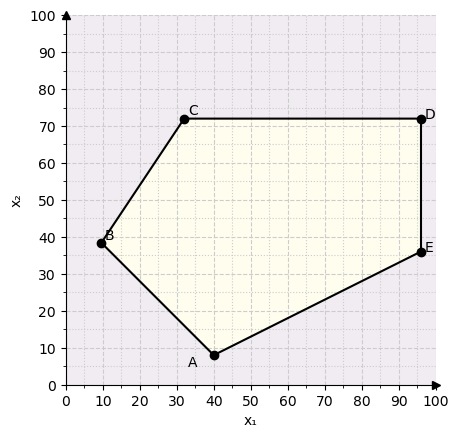

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator, MultipleLocator
figure, axes = plt.subplots()
axes.set_xlim(xmin=0,xmax=100)
axes.set_ylim(ymin=0,ymax=100)
axes.spines[["left", "bottom"]].set_position(("data", 0))
axes.spines["top"].set_visible(False)
axes.spines["right"].set_visible(False)
axes.plot(1, 0, ">k", transform=axes.get_yaxis_transform(), clip_on=False)
axes.plot(0, 1, "^k", transform=axes.get_xaxis_transform(), clip_on=False)
axes.xaxis.set_major_locator(MultipleLocator(10))
axes.yaxis.set_major_locator(MultipleLocator(10))
axes.xaxis.set_minor_locator(AutoMinorLocator(2))
axes.yaxis.set_minor_locator(AutoMinorLocator(2))
axes.grid(which='major', color='#CCCCCC', linestyle='--')
axes.grid(which='minor', color='#CCCCCC', linestyle=':')
plt.xlabel('x₁')
plt.ylabel('x₂')

d = np.linspace(0,100,3000)
x,y = np.meshgrid(d,d)

plt.imshow(((x+y>=48) & (x-2*y<=24) & (-3*x+2*y<=48) & (x >0) & (x<=96) & (y>0) & (y<=72)).astype(int),extent=(x.min(),x.max(),y.min(),y.max()),origin='lower',alpha=0.075)
x = np.linspace(0,96,3000)

dy1 = 48 - x
dy2 = x/2 - 12
dy3 = 24 + 1.5*x
dy4 = (x*0)+72
dy5 = x-96

idx13 = np.argwhere(np.diff(np.sign(dy1 - dy3))).flatten()
idx12 = np.argwhere(np.diff(np.sign(dy1 - dy2))).flatten()
idx34 = np.argwhere(np.diff(np.sign(dy3 - dy4))).flatten()

plt.plot(x[int(idx13):int(idx12)],dy1[int(idx13):int(idx12)],color='k') # 48 -x
plt.plot(x[int(idx12):],dy2[int(idx12):],color='k') # x/2 -12
plt.plot(x[int(idx13):int(idx34)],dy3[int(idx13):int(idx34)],color='k') # 24+1.5*x
plt.plot(x[int(idx34):],dy4[int(idx34):],color='k') #y=72
plt.vlines(x=96,ymin=36,ymax=72,color='k')

plt.plot(x[idx12], dy2[idx12], 'ko')
plt.text(x[idx34]+1, dy2[idx34]+1,"A")

plt.plot(x[idx13], dy3[idx13], 'ko')
plt.text(x[idx13]+1, dy3[idx13]+1, "B")

plt.plot(x[idx34], dy4[idx34], 'ko')
plt.text(x[idx34]+1, dy4[idx34]+1,"C")

plt.plot(96, 72, 'ko')

plt.text(97, 72,"D")

plt.text(97, 36,"E")

plt.plot(96,36,'ko')

Реализуем алгоритм Франк-Вульфа:

In [55]:
def frank_wolfe(funcs,d,d_rhs,X):
    x1,x2,l = symbols('x1 x2 l')
    ideal_points = []

    #Создание идеальных точек
    for f in funcs:
        res = linprog(c=f,A_ub=d,b_ub=d_rhs)
        ideal_points.append(round(res.fun*-1,2))
    print("F*",ideal_points,sep=': ')

    #Создание вспомогательной функции
    f1 = -1*funcs[0][0]*x1- 1*funcs[0][1]*x2
    f2 = -1*funcs[1][0]*x1 -1*funcs[1][1]*x2
    f3 = -1*funcs[2][0]*x1 -1*funcs[2][1]*x2
    fi  = (f1-ideal_points[0])**2 + (f2 - ideal_points[1])**2 + (f3 - ideal_points[2])**2
    fi1 = diff(fi,x1)
    fi2 = diff(fi,x2)
    k = 0
    prev_solution = 1
    prev = fi.subs({x1:X[0,0],x2:X[1,0]})
    print("ф({}):".format(k),prev)
    output = []
    while True:
        output.append([X[0,0],X[1,0]])
        x = X[0,0]
        y = X[1,0]
        aux = poly(fi1.subs({x1:x,x2:y})*x1+ fi2.subs({x1:x,x2:y})*x2)
        res = linprog(c=[aux.coeffs()[0],aux.coeffs()[1]],A_ub=d,b_ub=d_rhs)
        Xn = np.matrix([res.x[0],res.x[1]]).transpose()
        Xn = X + l*(Xn-X)
        fi_Xn = fi.subs({x1:Xn[0,0],x2:Xn[1,0]})
        solution = solve(diff(fi_Xn,l))[0]
        Xn = np.matrix([i[0,0].subs({l:solution}) for i in Xn]).transpose()
        cur = fi.subs({x1:Xn[0,0],x2:Xn[1,0]})
        if prev_solution - solution > 0.00001:
            X = Xn
            prev = cur
            prev_solution = solution
            k+=1
        else:
            break
    print("Ответ:")
    print(f"X{len(output)}=({X[0,0]},{X[1,0]})")
    print("f1", f1.subs({x1:X[0,0],x2:X[1,0]}),sep=":")
    print("f2", f2.subs({x1:X[0,0],x2:X[1,0]}),sep=":")
    print("f3", f3.subs({x1:X[0,0],x2:X[1,0]}),sep=":")
    return output

Подставим значения:

In [56]:
import numpy as np
from scipy.optimize import linprog
from sympy import symbols, diff, poly, solve

funcs = [[-1,-1],[3,-1],[-1,3]] # функции
d =  [[-1,-1],[1,-2],[-3,2],[-1,0],[1,0],[0,-1],[0,1]] # ограничения D
d_rhs =  [-48,24,48,0,96,0,72] #ограничения D, <= - отрицательный знак, >= - положительный
X = np.matrix([72,48]).transpose() # начальное приближение

points = frank_wolfe(funcs,d,d_rhs,X)

F*: [168.0, 9.6, 16.0]
ф(0): 41589.7600000000
Ответ:
X229=(25.5548469474863,23.9183395617879)
f1:49.4731865092742
f2:-52.7462012806710
f3:-46.2001717378775


Изобразим ход решения:

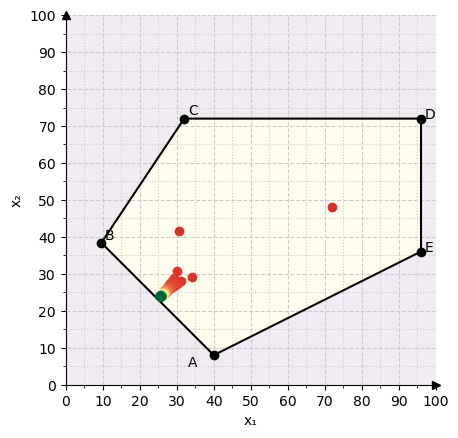

In [74]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator, MultipleLocator
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator, MultipleLocator
figure, axes = plt.subplots()
axes.set_xlim(xmin=0,xmax=100)
axes.set_ylim(ymin=0,ymax=100)
axes.spines[["left", "bottom"]].set_position(("data", 0))
axes.spines["top"].set_visible(False)
axes.spines["right"].set_visible(False)
axes.plot(1, 0, ">k", transform=axes.get_yaxis_transform(), clip_on=False)
axes.plot(0, 1, "^k", transform=axes.get_xaxis_transform(), clip_on=False)
axes.xaxis.set_major_locator(MultipleLocator(10))
axes.yaxis.set_major_locator(MultipleLocator(10))
axes.xaxis.set_minor_locator(AutoMinorLocator(2))
axes.yaxis.set_minor_locator(AutoMinorLocator(2))
axes.grid(which='major', color='#CCCCCC', linestyle='--')
axes.grid(which='minor', color='#CCCCCC', linestyle=':')
plt.xlabel('x₁')
plt.ylabel('x₂')

d = np.linspace(0,100,3000)
x,y = np.meshgrid(d,d)

plt.imshow(((x+y>=48) & (x-2*y<=24) & (-3*x+2*y<=48) & (x >0) & (x<=96) & (y>0) & (y<=72)).astype(int),extent=(x.min(),x.max(),y.min(),y.max()),origin='lower',alpha=0.075)
x = np.linspace(0,96,3000)

dy1 = 48 - x
dy2 = x/2 - 12
dy3 = 24 + 1.5*x
dy4 = (x*0)+72
dy5 = x-96

idx13 = np.argwhere(np.diff(np.sign(dy1 - dy3))).flatten()
idx12 = np.argwhere(np.diff(np.sign(dy1 - dy2))).flatten()
idx34 = np.argwhere(np.diff(np.sign(dy3 - dy4))).flatten()

plt.plot(x[int(idx13):int(idx12)],dy1[int(idx13):int(idx12)],color='k') # 48 -x
plt.plot(x[int(idx12):],dy2[int(idx12):],color='k') # x/2 -12
plt.plot(x[int(idx13):int(idx34)],dy3[int(idx13):int(idx34)],color='k') # 24+1.5*x
plt.plot(x[int(idx34):],dy4[int(idx34):],color='k') #y=72
plt.vlines(x=96,ymin=36,ymax=72,color='k')

plt.plot(x[idx12], dy2[idx12], 'ko')
plt.text(x[idx34]+1, dy2[idx34]+1,"A")

plt.plot(x[idx13], dy3[idx13], 'ko')
plt.text(x[idx13]+1, dy3[idx13]+1, "B")

plt.plot(x[idx34], dy4[idx34], 'ko')
plt.text(x[idx34]+1, dy4[idx34]+1,"C")

plt.plot(96, 72, 'ko')

plt.text(97, 72,"D")

plt.text(97, 36,"E")

plt.plot(96,36,'ko')


colors = plt.cm.RdYlGn(np.linspace(0.1, 1, len(points)))
for i in range(len(points)):
    plt.plot(points[i][0],points[i][1],marker='o',color=colors[i])